# Kevin's analysis Jupyter Notebook

This is going to be merged with Nik's once we have all the different analysis types we want put together

We start by pulling in the "environment classes" which has the ppo waterworld class inside

In [2]:
from util import environment_classes

let's start by training and examining an instance with a single agent, no cooperation


In [ ]:
# call the waterworld_ppo class with custom options -- only one agent needs to touch, and only one pursuer
single_agent = environment_classes.waterworld_ppo(log_dir='log_dir/single_agent_preset_env', n_coop = 1, n_pursuers = 1)

# we're going to run a train/test loop. 20 iterations of each, 100,000 steps per training loop, 10 games per evaluation set
single_agent.interlace_run(num_loops=5, num_games=3, num_steps=1000)

# now let's plot the results
single_agent.plot_rewards()

# and render each version. Start with the last model
single_agent.render_env(name_suffix='last')

# then the best
single_agent.load_version('best')
single_agent.render_env(name_suffix='best')

# and the worst
single_agent.load_version('worst')
single_agent.render_env(name_suffix='worst')

now let's try a basic 4 agent, cooperation = 2 setup. This doesn't use CTDE, so there isn't any coordinated learning in any way

In [3]:
basic_multi = environment_classes.waterworld_ppo(log_dir='log_dir/basic_multi_v2', n_coop = 2, n_pursuers = 4, local_ratio=0.75)

basic_multi.interlace_run(num_loops=100, num_games=10, num_steps=1000)
basic_multi.plot_rewards()

# and do some rendering
basic_multi.render_env(name_suffix='last')

# then the best
basic_multi.load_version('best')
basic_multi.render_env(name_suffix='best')

# and the worst
basic_multi.load_version('worst')
basic_multi.render_env(name_suffix='worst')

Finished loop 1 of 100
Finished loop 2 of 100
Finished loop 3 of 100
Finished loop 4 of 100
Finished loop 5 of 100
Finished loop 6 of 100
Finished loop 7 of 100
Finished loop 8 of 100
Finished loop 9 of 100
Finished loop 10 of 100
Finished loop 11 of 100
Finished loop 12 of 100
Finished loop 13 of 100
Finished loop 14 of 100
Finished loop 15 of 100
Finished loop 16 of 100
Finished loop 17 of 100
Finished loop 18 of 100
Finished loop 19 of 100
Finished loop 20 of 100
Finished loop 21 of 100
Finished loop 22 of 100
Finished loop 23 of 100
Finished loop 24 of 100
Finished loop 25 of 100


PermissionError: [Errno 13] Permission denied: 'log_dir/basic_multi_v2\\reward_logs.csv'

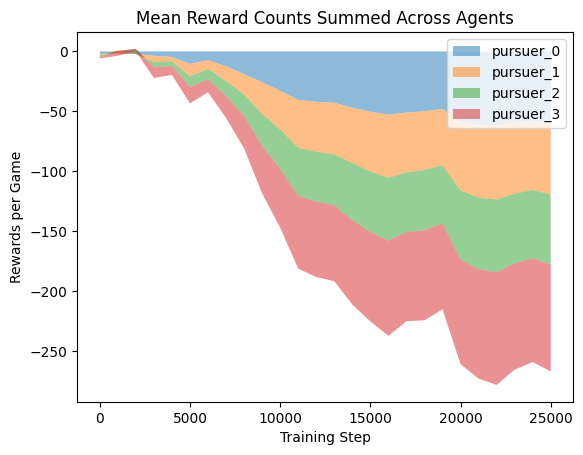

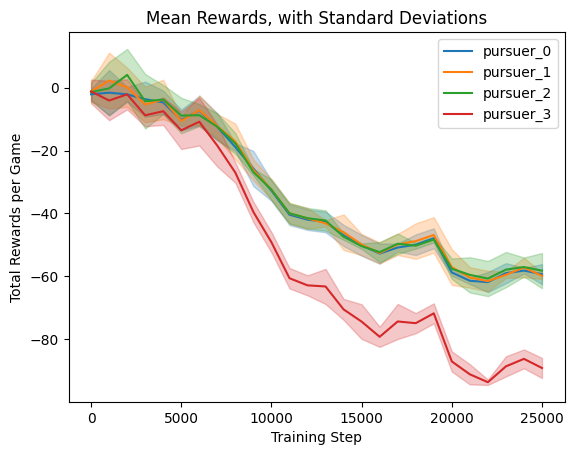

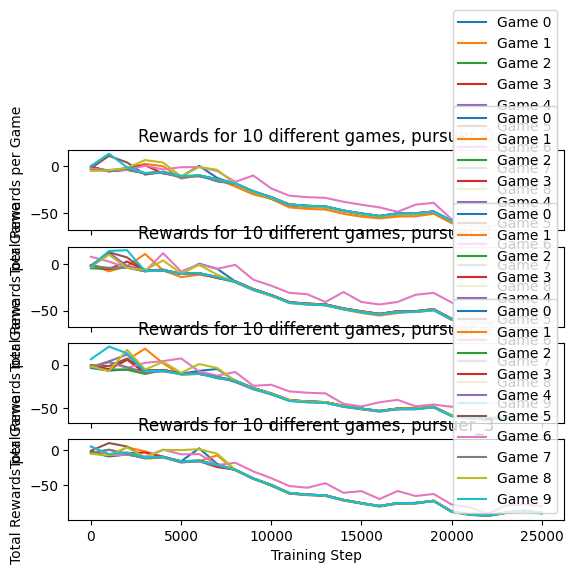

In [4]:
basic_multi.plot_rewards()

In [5]:
basic_multi.render_env(name_suffix='last')
